# Visual 
Visualised spectra and predictions

In [2]:
base = "data"
dataset = "nist"
kind = "in_database"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

max_mz = 1001
probs = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]

%load_ext autoreload
%autoreload 2

In [3]:
from matchms.importing import load_from_msp
from data_utils import spectrum_processing, get_n_samples, FixedSizeDS
from helpers import get_mz_vector, get_his_size
import numpy as np
from scipy.sparse import csr_matrix
from visual_utils import plot_spectrum_sample_prediction

# only for visual 
from spec2vec import SpectrumDocument
from data_utils import BasicCoder

In [4]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums
spectrums_train = get_spectra(data_train_path)
spectrums_val = get_spectra(data_val_path)
spectrums_test = get_spectra(data_test_path)

In [ ]:
documents_test = [SpectrumDocument(s, n_decimals=0) for s in spectrums_test]

In [6]:
datasets_indb = {
    "spec_train": spectrums_train, 
    "spec_val": spectrums_val, 
    "spec_val_5000": get_n_samples(spectrums_val, 5000),
    "spec_val_10000": get_n_samples(spectrums_val, 10000),
    "spec_test": spectrums_test, 
    "fixed_test": FixedSizeDS(spectrums_test)
}


In [7]:
base = "data"
dataset = "nist"
kind = "de_novo"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

max_mz = 1001

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
spectrums_train = get_spectra(data_train_path)
spectrums_val = get_spectra(data_val_path)
spectrums_test = get_spectra(data_test_path)

In [9]:
documents_test = [SpectrumDocument(s, n_decimals=0) for s in spectrums_test]

In [10]:
datasets_denovo = {
    "spec_train": spectrums_train, 
    "spec_val": spectrums_val, 
    "spec_val_5000": get_n_samples(spectrums_val, 5000),
    "spec_val_10000": get_n_samples(spectrums_val, 10000),
    "spec_test": spectrums_test, 
    "fixed_test": FixedSizeDS(spectrums_test)
}


# To mz

In [11]:
from gensim.models import Word2Vec
from model_evaluation import model_selection, model_selection_random
wv_path_indb = f"gas2vec/in_database.model"
wv_path_dn = f"gas2vec/de_novo.model"


w2v_indb = Word2Vec.load(wv_path_indb)
w2v_dn = Word2Vec.load(wv_path_dn)

In [12]:
def ids_to_mz(xs, i2e):
    res = []
    for x in xs:
        res.append(int(i2e[int(x)].split("@")[-1]))
    return np.array(res)

## In database


In [13]:
i2e = w2v_indb.wv.index2entity
_, scores_gpt = model_selection("predictions/in_database", "hugg_test", kw="gpt2", up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None, return_details=True)

gpt2_ns_auto
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
Selected up to k=30, l=None, to_rel_inten=0.2
[21122 22328 22520 22555 22561 22559 22562 22562 22563 22530 22501 22451
 22407 22354 22277 22205 22122 22016 21919 21799 21656 21519 21381 21214
 21040 20846 20638 20437 20264 20044]


In [14]:
preds, ys = scores_gpt["gpt2_ns_auto"]["dets"]["all"].values()

In [19]:
def plot_beauty(ds, i, k, preds, ys, i2e, kw="nic", kind="in_database", topk=True):
    spec = ds[i]
    if topk:
        missing_ind = np.argsort(spec.peaks.intensities)[::-1][k:]
        missing_mz = spec.peaks.mz[missing_ind]
    else:
        missing_mz = []
    if topk:
        k = k-1
    pred = preds[k][i]
    y = ys[k][i]
    if y is None or pred is None:
        print("not enough peaks")
        return
   
    if topk:
        pred = ids_to_mz(pred, i2e)
        y = ids_to_mz(y, i2e)
    
    TP = set(y).intersection(pred)
    FN = set(y).difference(pred)
    FP = set(pred).difference(y)
    
    plot_spectrum_sample_prediction(spec, missing_mz=missing_mz, TP_mz=TP, FN_mz=FN, FP_mz=FP,\
                                    max_mz=1001, \
                                    save_to_path=f"figures/{kind}/treecol/{kw}-{i}-{k}.pdf")

25
25
25


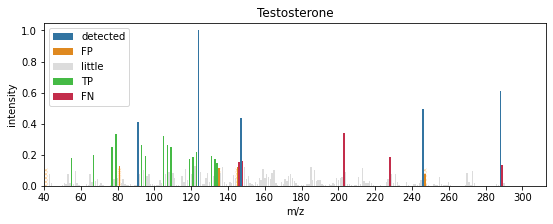

In [40]:
plot_beauty(datasets_indb["spec_test"], 17965, 5, preds, ys, i2e)

50
50
50


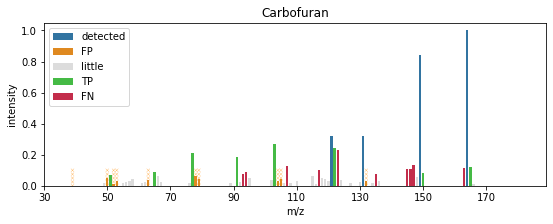

In [41]:
plot_beauty(datasets_indb["spec_test"], 13766, 4, preds, ys, i2e)

In [42]:
i2e = w2v_indb.wv.index2entity
_, scores_mlp = model_selection_random("predictions/in_database", "fixed_test", kw="mlp_2", return_details=True)

mlp_2_.3


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


In [43]:
preds, ys = scores_mlp["mlp_2_.3"]["all"].values()

10
10
10


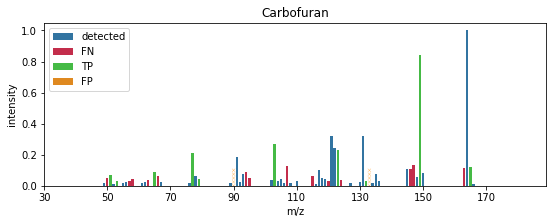

In [44]:
plot_beauty(datasets_indb["fixed_test"].spectrums, 13766, 10, preds, ys, i2e, kind="in_database", kw="mlp", topk=False)

10
10
10


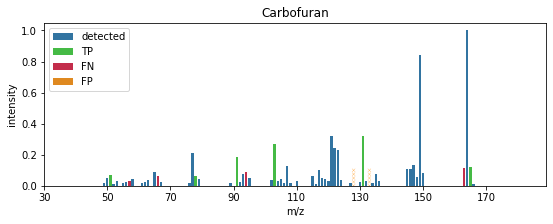

In [46]:
plot_beauty(datasets_indb["fixed_test"].spectrums, 13766, 5, preds, ys, i2e, kind="in_database", kw="mlp", topk=False)

15
15
15


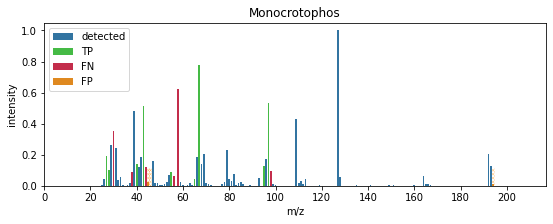

In [45]:
plot_beauty(datasets_indb["fixed_test"].spectrums, 14046, 8, preds, ys, i2e, kind="in_database", kw="mlp", topk=False)

30
30
30


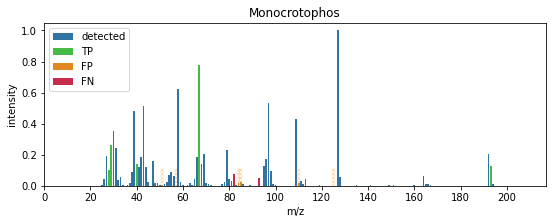

In [47]:
plot_beauty(datasets_indb["fixed_test"].spectrums, 14046, 5, preds, ys, i2e, kind="in_database", kw="mlp", topk=False)

## De novo


In [48]:
i2e = w2v_dn.wv.index2entity
_, scores_gpt = model_selection("predictions/de_novo", "hugg_test", kw="gpt2_h6l6_auto", up_to_k=30, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None, return_details=True)

gpt2_h6l6_auto
Possible k up to 30, predict up to 20 peaks
Selected up to k=30, l=4, j=6
Selected up to k=30, l=None, to_rel_inten=0.2
skipped spectrum - unknown peak
[25764 27550 27864 27892 27905 27907 27906 27901 27906 27850 27804 27770
 27718 27634 27545 27493 27413 27326 27245 27163 27066 26955 26857 26746
 26611 26501 26363 26237 26100 25960]


In [49]:
preds, ys = scores_gpt["gpt2_h6l6_auto"]["dets"]["all"].values()

50
50
50


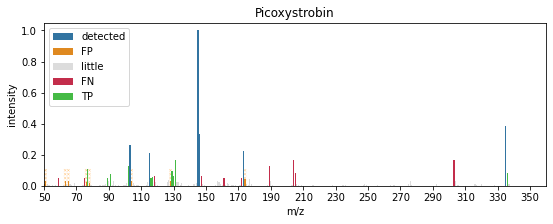

In [54]:
plot_beauty(datasets_denovo["spec_test"], 22464, 6, preds, ys, i2e, kind="de_novo", topk=True)

45
45
45


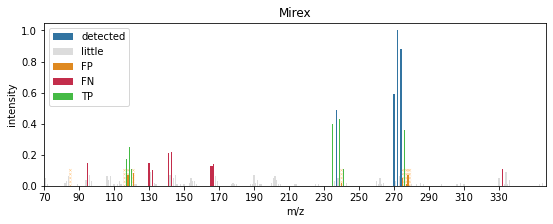

In [55]:
plot_beauty(datasets_denovo["spec_test"], 27347, 4, preds, ys, i2e, kind="de_novo", topk=True)

In [56]:
i2e = w2v_dn.wv.index2entity
_, scores_mlp = model_selection_random("predictions/de_novo", "fixed_test", kw="mlp", return_details=True)

mlp_3_.3


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mr": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


In [57]:
preds, ys = scores_mlp["mlp_3_.3"]["all"].values()

In [ ]:
plot_beauty(datasets_denovo["fixed_test"].spectrums, 23073, 4, preds, ys, i2e, kind="de_novo", kw="mlp", topk=False)

10
10
10


# Plot example spectra

In [55]:
from visual_utils import plot_spectrum_sample, plot_spectrum_sample_missing, plot_spectrum_sample_prediction, plot_spectrum_sample_metric

In [20]:
datasets_indb["spec_test"][13766].peaks.intensities
np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1]

array([57, 54, 39, 45, 26, 40, 41, 16, 20, 52, 30, 58, 56, 51, 50, 35, 23,
       12, 55, 48, 22,  2, 33, 13, 17, 53,  1, 36, 24,  8, 18, 28, 37, 11,
       60, 25, 42, 46, 32, 49,  7, 27,  4, 38, 14, 10, 21,  6, 44,  5, 47,
        0, 31, 19, 43, 15,  9, 29, 34,  3, 59])

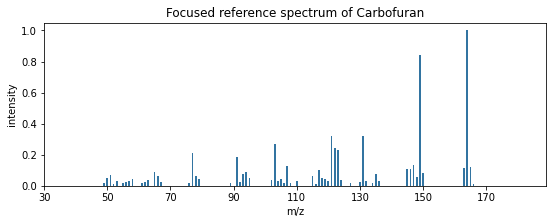

In [65]:
plot_spectrum_sample(datasets_indb["spec_test"][13766], max_mz=1001, save_to_path="figures/carbofuran.pdf")

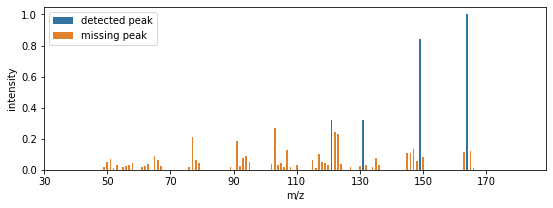

In [45]:
k=4
missing_ind = np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k:]
missing_mz = datasets_indb["spec_test"][13766].peaks.mz[missing_ind]
plot_spectrum_sample_missing(datasets_indb["spec_test"][13766], missing_mz, max_mz=1001, save_to_path="figures/carbofuran_topk.pdf")

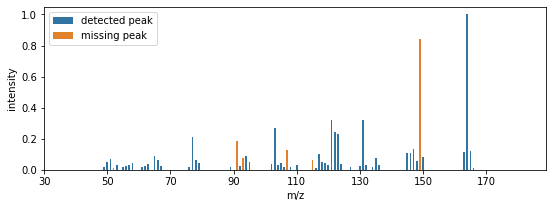

In [63]:
plot_spectrum_sample_missing(datasets_indb["spec_test"][13766], np.array([52,91,93,107,115, 149]), max_mz=1001, save_to_path="figures/carbofuran_rand.pdf")

{65.0, 163.0, 165.0, 135.0, 103.0, 107.0, 123.0, 77.0, 145.0, 146.0, 147.0, 51.0, 117.0, 150.0, 122.0, 91.0, 93.0, 94.0}


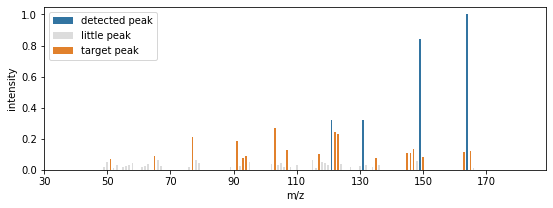

In [58]:
k=4
missing_ind = np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k:]
missing_mz = datasets_indb["spec_test"][13766].peaks.mz[missing_ind]
last_int = np.sort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k-1]
little_ind = np.nonzero(datasets_indb["spec_test"][13766].peaks.intensities <= last_int*0.2)
little_mz = datasets_indb["spec_test"][13766].peaks.mz[little_ind]

print(set(missing_mz).difference(set(little_mz)))
plot_spectrum_sample_metric(datasets_indb["spec_test"][13766], missing_mz=missing_mz, little_mz=little_mz, max_mz=1001, save_to_path="figures/carbofuran_topk_metric.pdf")

{65.0, 163.0, 165.0, 135.0, 103.0, 107.0, 123.0, 77.0, 145.0, 146.0, 147.0, 51.0, 117.0, 150.0, 122.0, 91.0, 93.0, 94.0}


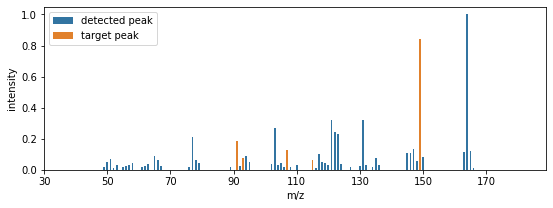

In [ ]:
k=4
missing_ind = np.argsort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k:]
missing_mz = datasets_indb["spec_test"][13766].peaks.mz[missing_ind]
last_int = np.sort(datasets_indb["spec_test"][13766].peaks.intensities)[::-1][k-1]
little_ind = np.nonzero(datasets_indb["spec_test"][13766].peaks.intensities <= last_int*0.2)
little_mz = datasets_indb["spec_test"][13766].peaks.mz[little_ind]

print(set(missing_mz).difference(set(little_mz)))
plot_spectrum_sample_metric(datasets_indb["spec_test"][13766], missing_mz=[91,93,107,115, 149], little_mz=[], max_mz=1001, save_to_path="figures/carbofuran_rand_metric.pdf")